<a href="https://colab.research.google.com/github/NandithaSHadligere/CulturalHeritage/blob/main/HeritageAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

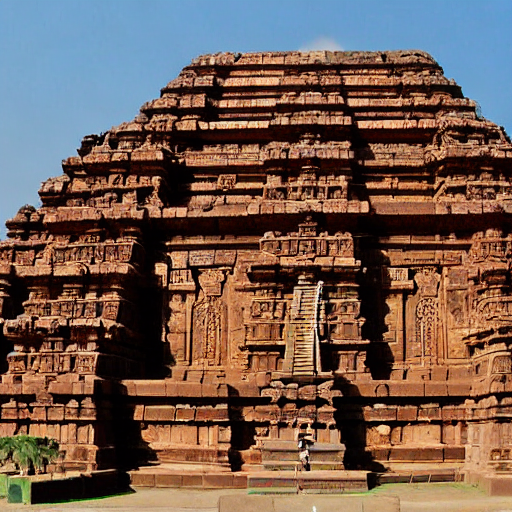

In [2]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import display  # To display images in Jupyter Notebook

# Load the pre-trained Stable Diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

# Function to generate an image
def generate_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        image = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    return image

# Example usage
prompt = "Konarak temple"
image = generate_image(prompt)

# Display the image in Jupyter Notebook
display(image)

# Save the generated image
image.save("sun_temple.png")


  0%|          | 0/50 [00:00<?, ?it/s]

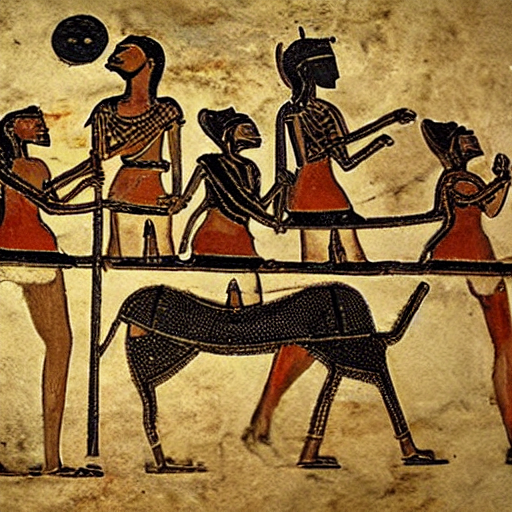

In [3]:
prompt = "Harappan civilization"
image = generate_image(prompt)

# Display the image in Jupyter Notebook
display(image)

# Save the generated image
image.save("harappan.png")


  0%|          | 0/50 [00:00<?, ?it/s]

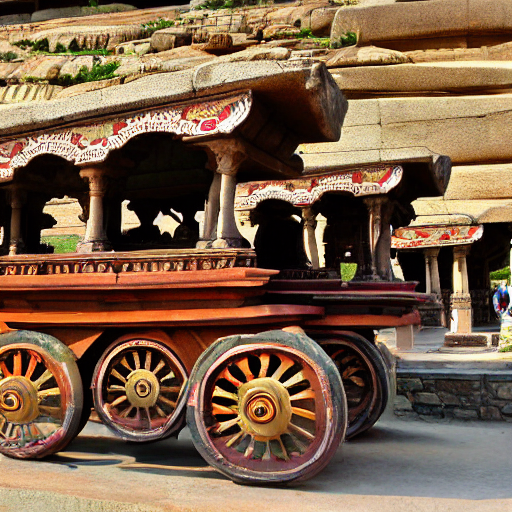

In [5]:
prompt = "Hampi chariot"
image = generate_image(prompt)

# Display the image in Jupyter Notebook
display(image)

# Save the generated image
image.save("stone_chariot.png")


Step 1: Generate Depth Map

In [ ]:
import torch
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Check device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load MiDaS model
midas_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_model.eval().to(device)

# Load transforms to prepare the image for the model
transform = Compose([
    Resize(384),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def download_image(url):
    """Download image from a URL and return it as a NumPy array."""
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))  # Open image from bytes
        img = img.convert("RGB")  # Ensure it's in RGB format
        return np.array(img)  # Convert to NumPy array
    else:
        raise ValueError(f"Error: Unable to download image from {url}")

def estimate_depth(image_path):
    """Estimate depth from an image URL or local file path."""
    if image_path.startswith("http"):
        img = download_image(image_path)  # Download image from URL
    else:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Error: Unable to load image at {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = Image.fromarray(img)  # Convert NumPy array to PIL Image
    img_input = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        depth = midas_model(img_input)
        depth = depth.squeeze().cpu().numpy()

    depth_min, depth_max = depth.min(), depth.max()
    depth_normalized = (depth - depth_min) / (depth_max - depth_min)

    return depth_normalized

# Estimate depth
image_url = "https://github.com/NandithaSHadligere/CulturalHeritage/blob/main/sun_temple.png?raw=true"
depth_map = estimate_depth(image_url)

# Save depth map as an image
cv2.imwrite("depth_map.png", (depth_map * 255).astype(np.uint8))
print("Depth estimation completed! Saved as depth_map.png.")


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

Depth estimation completed! Saved as depth_map.png.


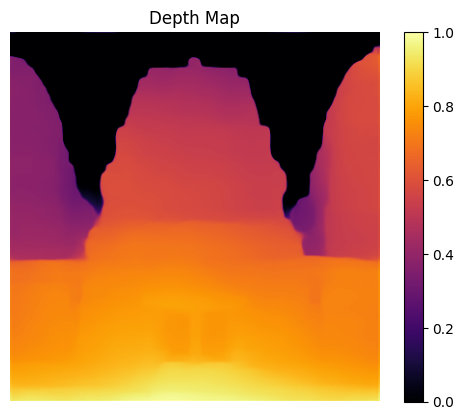

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(depth_map, cmap="inferno")  # Use 'inferno' for better visualization
plt.colorbar()  # Show color scale
plt.title("Depth Map")
plt.axis("off")  # Hide axes
plt.show()

In [1]:
pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Unins

Step 2: Create 3D Mesh

In [4]:
import open3d as o3d
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO

def download_image(url, filename):
    """Downloads an image from a URL and saves it locally."""
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        img = img.convert("RGB")  # Ensure it's in RGB format
        img.save(filename)  # Save it locally
        return filename
    else:
        raise ValueError(f"Error: Unable to download image from {url}")

def create_mesh_from_depth_map(depth_map_path, image_path):
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image_path)

    if depth_map is None:
        print(f"Error: Unable to load depth map from {depth_map_path}")
        return None
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None

    h, w = depth_map.shape

    fx = fy = max(h, w) / 2  # Approximate focal length
    cx, cy = w / 2, h / 2

    # Create point cloud
    points = []
    colors = []
    for v in range(h):
        for u in range(w):
            z = depth_map[v, u] / 255.0  # Normalize depth
            if z > 0:
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])
                colors.append(image[v, u].astype(np.float32) / 255.0)

    if len(points) == 0:
        print("Error: No valid 3D points generated from depth map.")
        return None

    points = np.array(points)
    colors = np.array(colors)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    # Ensure there are enough points for meshing
    if len(points) < 50:
        print("Error: Not enough points for meshing.")
        return None

    # Estimate normals
    point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))

    # Create mesh using Poisson Reconstruction (alternative to Ball Pivoting)
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=8)

    mesh.compute_vertex_normals()

    return mesh

depth_map_url = "https://github.com/NandithaSHadligere/CulturalHeritage/blob/main/depth_map.png?raw=true"
image_url = "https://github.com/NandithaSHadligere/CulturalHeritage/blob/main/sun_temple.png?raw=true"

# Download images first
depth_map_path = download_image(depth_map_url, "depth_map.png")
image_path = download_image(image_url, "sun_temple.png")

# Create 3D mesh
mesh = create_mesh_from_depth_map(depth_map_path, image_path)

if mesh:
    o3d.io.write_triangle_mesh("sun_temple_3d.ply", mesh)
    print("3D mesh successfully created and saved.")


3D mesh successfully created and saved.


In [3]:
import open3d as o3d

# Check Open3D version
print("Open3D Version:", o3d.__version__)

# Check if Open3D is built with CUDA support
if o3d.core.cuda.device_count() > 0:
    print("CUDA is available. GPU can be used.")
else:
    print("CUDA is NOT available. Open3D is using CPU.")


Open3D Version: 0.19.0
CUDA is available. GPU can be used.


In [4]:
import open3d as o3d

try:
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)
    print("✅ OpenGL successfully initialized.")
    vis.destroy_window()
except Exception as e:
    print(f"❌ OpenGL Error: {e}")


[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
✅ OpenGL successfully initialized.


In [1]:
pip install --upgrade open3d


In [4]:
!apt-get update
!apt-get install -y libgl1-mesa-dev libgl1-mesa-glx libosmesa6 libosmesa6-dev


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [6]:
import os

os.environ["PYOPENGL_PLATFORM"] = "osmesa"  # Use OSMesa for headless rendering
os.environ["MESA_GL_VERSION_OVERRIDE"] = "4.5"  # Override OpenGL version
os.environ["MESA_LOADER_DRIVER_OVERRIDE"] = "swrast"  # Use software rendering


In [ ]:
import open3d as o3d

# Load the mesh
mesh = o3d.io.read_triangle_mesh("sun_temple_3d.ply")
mesh.compute_vertex_normals()

# Create a visualizer in headless mode
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)  # No GUI
vis.add_geometry(mesh)
vis.run()
vis.capture_screen_image("mesh_output.png")  # Save the image
vis.destroy_window()

# Display the saved image
from IPython.display import display
from PIL import Image

img = Image.open("mesh_output.png")
display(img)
